<a href="https://colab.research.google.com/github/sst52/Neural-Nets/blob/master/Generative_Adversarial_Neural_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Downloading and Supporting dataset

import os
import zipfile
import requests
import math
import numpy as np
from PIL import Image
from tqdm import tqdm

DEBUG = False

def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value
  return None

def save_response_content(response, destination, chunk_size=32*1024):
  total_size = int(response.headers.get('content-length', 0))
  with open(destination, "wb") as f:
    for chunk in tqdm(response.iter_content(chunk_size), total=total_size,
		unit='B', unit_scale=True, desc=destination):
      if chunk: # filter out keep-alive new chunks
        f.write(chunk)

def download_file_from_google_drive(id, destination):
  print("Downloading into ./data/... Please wait.")
  URL = "https://docs.google.com/uc?export=download"
  session = requests.Session()

  response = session.get(URL, params={ 'id': id }, stream=True)
  token = get_confirm_token(response)

  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params=params, stream=True)

  save_response_content(response, destination)
  print("Done.")

def download_celeb_a():
  dirpath = './data'
  data_dir = 'celebA'
  if os.path.exists(os.path.join(dirpath, data_dir)):
    print('Found Celeb-A - skip')
    return

  filename, drive_id  = "img_align_celeba.zip", "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
  save_path = os.path.join(dirpath, filename)

  if os.path.exists(save_path):
    print('[*] {} already exists'.format(save_path))
  else:
    download_file_from_google_drive(drive_id, save_path)

  if not DEBUG:
    zip_dir = ''
    with zipfile.ZipFile(save_path) as zf:
      zip_dir = zf.namelist()[0]
      zf.extractall(dirpath)
    os.remove(save_path)
    os.rename(os.path.join(dirpath, zip_dir), os.path.join(dirpath, data_dir))

def images_square_grid(images, mode='RGB'):
    
    # Get maximum size for square grid of images
    save_size = math.floor(tf.sqrt(images.shape[0]))
    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = tf.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

In [23]:
# python spyder notebook
# @author:sunkara

data_dir = './content/data'
download_celeb_a()

Found Celeb-A - skip


In [0]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np

In [0]:
# Image configuration
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
data_files = glob(os.path.join(data_dir, 'celebA/*.jpg'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3

def get_image(image_path, width, height, mode):

    image = Image.open(image_path)

    '''
    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)
    '''
    return np.array(image.convert(mode))

In [0]:
def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

In [0]:
def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255


    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size],
            *shape[1:3])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


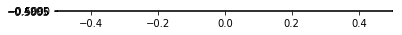

In [34]:
test_images = get_batch(glob(os.path.join(data_dir, 'celebA/*.jpg'))[:10], 56, 56)
pyplot.imshow(test_images)

In [0]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

In [0]:
def generator(z, out_channel_dim, is_train=True):
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

In [0]:
def discriminator(images, reuse=False):
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

In [0]:
# loss function
def model_loss(input_real, input_z, out_channel_dim):
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

In [0]:
# optimization
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [0]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(samples)
    pyplot.show()

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):

    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])

In [0]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)